In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models, datasets

In [3]:
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 2.3 MB/s eta 0:00:0000:0100:01


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import sys
from tqdm.auto import tqdm
import time
import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
def get_data_loader(data_dir, batch_size, train=False):
    if train:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.3),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, 'train/'), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, 'valid/'), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        
        test_data = datasets.ImageFolder(os.path.join(data_dir, 'test/'), transform=transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
       
        return val_loader, test_loader, len(val_data), len(test_data)

In [8]:
DATA_DIR = '../input/butterfly-images40-species'

In [9]:
classes = get_classes(os.path.join(DATA_DIR, 'train/'))
len(classes)

75

In [10]:
(train_loader, train_data_len) = get_data_loader(DATA_DIR, 128, True)
(val_loader, test_loader, val_data_len, test_data_len) = get_data_loader(DATA_DIR, 128, False)

In [13]:
dataloaders = {
    "train":train_loader,
    "val":val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val":val_data_len
}
dataset_sizes

{'train': 9285, 'val': 375}

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


  0%|          | 0.00/21.9M [00:00<?, ?B/s]

In [16]:
for params in model.parameters():
    params.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model.head

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=75, bias=True)
)

In [17]:
model.to(device)
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.head.parameters(), lr=0.001)

In [18]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.97)
lr_scheduler

In [ ]:
device

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: 
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() 
            
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) 
        print()
    time_elapsed = time.time() - since 
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, lr_scheduler)

In [28]:
for i, l in test_loader:
    break
i.size(0), i.shape, l.data[1]

(128, torch.Size([128, 3, 224, 224]), tensor(14))

In [43]:
test_loss = 0.0
class_correct = [0 for i in range(len(classes))]
class_total = [0 for i in range(len(classes))]
model.eval()
num_classes = len(classes)

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
    _, pred = torch.max(output, 1)
    test_loss = loss.item()*data.size(0)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 128:
        for i in range(128):
            label = target.data[i]
            class_correct[label] += correct[i]
            class_total[label] += 1
test_loss = test_loss / test_data_len
print("Test Loss {:.4f}".format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d%2d)' % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print('Test Accuracy {} is NA'.format(classes[i]))
print('Test Accuracy of %2d%% (%2d%2d)' % (
            np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))   

  0%|          | 0/3 [00:00<?, ?it/s]

Test Loss 0.3723
Test Accuracy of ADONIS: 100% ( 4 4)
Test Accuracy of AFRICAN GIANT SWALLOWTAIL: 100% ( 3 3)
Test Accuracy AMERICAN SNOOT is NA
Test Accuracy of AN 88: 100% ( 5 5)
Test Accuracy of APPOLLO: 100% ( 2 2)
Test Accuracy of ATALA: 100% ( 3 3)
Test Accuracy of BANDED ORANGE HELICONIAN: 100% ( 2 2)
Test Accuracy of BANDED PEACOCK: 100% ( 4 4)
Test Accuracy of BECKERS WHITE: 100% ( 3 3)
Test Accuracy of BLACK HAIRSTREAK: 100% ( 4 4)
Test Accuracy of BLUE MORPHO: 66% ( 2 3)
Test Accuracy of BLUE SPOTTED CROW: 100% ( 2 2)
Test Accuracy of BROWN SIPROETA: 100% ( 3 3)
Test Accuracy of CABBAGE WHITE: 100% ( 4 4)
Test Accuracy of CAIRNS BIRDWING: 80% ( 4 5)
Test Accuracy of CHECQUERED SKIPPER: 100% ( 5 5)
Test Accuracy of CHESTNUT: 100% ( 5 5)
Test Accuracy of CLEOPATRA: 100% ( 4 4)
Test Accuracy of CLODIUS PARNASSIAN: 100% ( 2 2)
Test Accuracy of CLOUDED SULPHUR: 100% ( 4 4)
Test Accuracy of COMMON BANDED AWL: 100% ( 4 4)
Test Accuracy of COMMON WOOD-NYMPH: 100% ( 3 3)
Test Accurac

In [51]:
for img, label in test_loader:
    break
label[0].item()

61

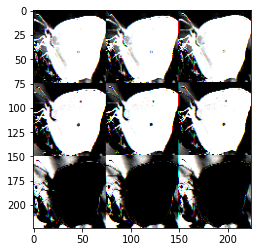

Predicted CLEOPATRA
Answer CLEOPATRA


In [85]:
import matplotlib.pyplot as plt
def predict_img(image, label):
    image = image.unsqueeze(0)
    image, label = image.to(device), label.to(device).item()
    with torch.no_grad():
        output = model(image)
    _, pred = torch.max(output, -1)
    image = image.reshape((image.shape[2], image.shape[2], image.shape[1]))
    plt.imshow(image.cpu())
    plt.show()
    print('Predicted {}'.format(classes[pred]))
    print('Answer {}'.format(classes[label]))

random_index = np.random.randint(1, 128)
predict_img(img[random_index], label[random_index])

In [90]:
classes

['ADONIS',
 'AFRICAN GIANT SWALLOWTAIL',
 'AMERICAN SNOOT',
 'AN 88',
 'APPOLLO',
 'ATALA',
 'BANDED ORANGE HELICONIAN',
 'BANDED PEACOCK',
 'BECKERS WHITE',
 'BLACK HAIRSTREAK',
 'BLUE MORPHO',
 'BLUE SPOTTED CROW',
 'BROWN SIPROETA',
 'CABBAGE WHITE',
 'CAIRNS BIRDWING',
 'CHECQUERED SKIPPER',
 'CHESTNUT',
 'CLEOPATRA',
 'CLODIUS PARNASSIAN',
 'CLOUDED SULPHUR',
 'COMMON BANDED AWL',
 'COMMON WOOD-NYMPH',
 'COPPER TAIL',
 'CRECENT',
 'CRIMSON PATCH',
 'DANAID EGGFLY',
 'EASTERN COMA',
 'EASTERN DAPPLE WHITE',
 'EASTERN PINE ELFIN',
 'ELBOWED PIERROT',
 'GOLD BANDED',
 'GREAT EGGFLY',
 'GREAT JAY',
 'GREEN CELLED CATTLEHEART',
 'GREY HAIRSTREAK',
 'INDRA SWALLOW',
 'IPHICLUS SISTER',
 'JULIA',
 'LARGE MARBLE',
 'MALACHITE',
 'MANGROVE SKIPPER',
 'MESTRA',
 'METALMARK',
 'MILBERTS TORTOISESHELL',
 'MONARCH',
 'MOURNING CLOAK',
 'ORANGE OAKLEAF',
 'ORANGE TIP',
 'ORCHARD SWALLOW',
 'PAINTED LADY',
 'PAPER KITE',
 'PEACOCK',
 'PINE WHITE',
 'PIPEVINE SWALLOW',
 'POPINJAY',
 'PURPLE HAIRS

In [99]:
precison = precision_score(class_correct, class_total, average='weighted')
recall = recall_score(class_correct, class_total, average='weighted')
f1 = f1_score(class_correct, class_total, average='weighted')
print('F1-score {}'.format(f1))
print('precison {}'.format(precison))
print('recall {}'.format(recall))

F1-score 0.7812271704903283
precison 0.8050740740740742
recall 0.8


In [107]:
torch.save(model, './model.pt')